# Imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.contrib import keras
from sklearn import datasets
from sklearn import linear_model
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

/home/galtay/anaconda3/envs/ml/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Simple Mock Data

Lets create a simple mock dataset with one independent variable and one dependent variable with a little noise. 

In [2]:
Nsamp = 50
Nfeatures = 1
xarr = np.linspace(-0.5, 0.5, Nsamp)
np.random.seed(83749)
beta_0 = -2.0
beta_1 = 4.3
yarr = (beta_0 + beta_1 * xarr) + (np.random.normal(size=Nsamp) * 0.5)

mdl = linear_model.LinearRegression(fit_intercept=False)
mdl = mdl.fit(np.c_[np.ones(Nsamp), xarr], yarr)
mdl.coef_

array([-2.0517912 ,  4.08511933])

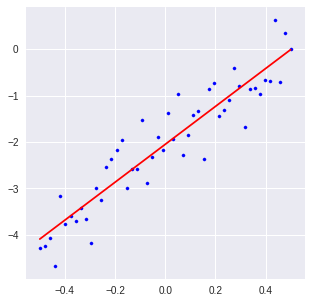

In [3]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(xarr, yarr, s=10, color='blue')
plt.plot(xarr, mdl.coef_[0] + mdl.coef_[1] * xarr, color='red')

In [5]:
ph_x = tf.placeholder(tf.float32, [None, Nfeatures], name='features')
ph_y = tf.placeholder(tf.float32, [None, 1], name='output')
ph_x, ph_y

# Set model weights
v_W = tf.Variable(tf.random_normal([Nfeatures, 1]), name='weights')
v_b = tf.Variable(tf.zeros([1]), name='bias')
v_z = tf.matmul(ph_x, v_W) + v_b
cost_1 = tf.squared_difference(v_z, ph_y)
cost_2 = tf.reduce_mean(cost_1)

learning_rate=0.1
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_2)
# Construct model and encapsulating all ops into scopes, making
# Tensorboard's Graph visualization more convenient
#with tf.name_scope('Model'):
#    # Model
#    pred = tf.matmul(x, W) + b # basic linear regression
#with tf.name_scope('Loss'):
#    # Minimize error (mean squared error)
#    cost = tf.reduce_mean(-tf.reduce_sum(y - pred)*tf.log(pred), reduction_indices=1))
#with tf.name_scope('SGD'):
#    # Gradient Descent
#    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
#with tf.name_scope('Accuracy'):
#    # Accuracy
#    acc = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
#    acc = tf.reduce_mean(tf.cast(acc, tf.float32))



In [6]:
init = tf.global_variables_initializer()

merged = tf.summary.merge_all()



# Launch the graph
feed_dict = {ph_x: xarr.reshape(Nsamp, 1), ph_y: yarr.reshape(Nsamp,1)}
with tf.Session() as sess:
    train_writer = tf.summary.FileWriter('/tmp/tensorflow/logs', sess.graph)
    
    sess.run(init)
    z_out = sess.run(v_z, feed_dict=feed_dict)
    cost_1_out = sess.run(cost_1, feed_dict=feed_dict)
    cost_2_out = sess.run(cost_2, feed_dict=feed_dict)
    for i in range(300):
        train_step_out = sess.run(train_step, feed_dict=feed_dict)
    W_out = sess.run(v_W, feed_dict=feed_dict)
    b_out = sess.run(v_b, feed_dict=feed_dict)

print(W_out)
print(b_out)


[[ 4.06889343]]
[-2.05179071]


# Boston Housing Dataset

  - ## `feautres`: raw features variables in DataFrame 
  - ## `target`: raw target variable in DataFrame

In [ ]:
boston = datasets.load_boston()
print(boston['DESCR'])
features = pd.DataFrame(data=boston['data'], columns=boston['feature_names'])
target = pd.DataFrame(data=boston['target'], columns=['MEDV'])

In [ ]:
features.head(5)

In [ ]:
target.head(5)

In [ ]:
hh = features.hist(figsize=(14,18))

# Center and Normalize

In [ ]:
from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler()
scalerX.fit(features)
dfXn = pd.DataFrame(data=scalerX.transform(features), columns=features.columns)
scalerY = StandardScaler()
scalerY.fit(target)
dfYn = pd.DataFrame(data=scalerY.transform(target), columns=target.columns)

In [ ]:
dfXn.head(5)

In [ ]:
dfYn.head(5)

# Statsmodels Linear Regression

In [ ]:
dfXn1 = dfXn.copy()
dfXn1.insert(loc=0, column='intercept', value=1)
results = sm.OLS(dfYn, dfXn1).fit()
print(results.summary())

In [ ]:
dfYn.max()
target.max()

In [ ]:
plt.scatter(dfYn.values, results.fittedvalues.values)

In [ ]:
from sklearn import linear_model
mdl = linear_model.LinearRegression(fit_intercept=False)
mdl = mdl.fit(dfXn1.values, dfYn.values)

In [ ]:
print('n_params (statsmodels): ', len(results.params))
print('n params (sklearn linear): ', len(mdl.coef_.flatten()))

In [ ]:
print(results.params)
print()
print(mdl.coef_)

In [ ]:
np.all(np.abs(mdl.coef_ - results.params.values) < 1.0e-10)

In [ ]:
plt.scatter(dfYn.values, mdl.predict(dfXn1.values).flatten())

# Linear Regression, Keras

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, InputLayer
from keras.optimizers import SGD, Adam, RMSprop
from keras.losses import mean_squared_error

In [ ]:
nfeatures = features.shape[1]
model = Sequential()
model.add(InputLayer(input_shape=(nfeatures,), name='input'))
model.add(Dense(1, kernel_initializer='uniform', activation='linear', name='dense_1'))
model.summary()
weights_initial = model.get_weights()

print('weights_initial - input nodes: \n', weights_initial[0])
print('weights_initial - bias node: ', weights_initial[1])

In [ ]:
model.compile(optimizer=RMSprop(lr=0.001), loss='mean_squared_error')

In [ ]:
dfYn.shape

In [ ]:
model.set_weights(weights_initial)
history = model.fit(dfXn.values, dfYn.values, epochs=5000, batch_size=dfYn.shape[0], verbose=0)

In [ ]:
plt.plot(history.history['loss'])

In [ ]:
model.get_weights()

In [ ]:
mdl.coef_

In [ ]:
plt.scatter(model.get_weights()[0].flatten(), mdl.coef_.flatten()[1:])

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(dfYn.values, mdl.predict(dfXn1.values).flatten(), color='red', alpha=0.6, marker='o')
plt.scatter(dfYn.values, model.predict(dfXn.values), color='blue', alpha=0.6, marker='+')

In [ ]:
# tf Graph Input

# input data 
n_samples, n_features = features.shape
x = tf.placeholder(tf.float32, [None, n_features], name='InputData')
# output data 
y = tf.placeholder(tf.float32, [None, 1], name='TargetData')

# Set model weights
W = tf.Variable(tf.random_normal([n_features, 1]), name='Weights')
b = tf.Variable(tf.zeros([1]), name='Bias')
z = tf.matmul(x,W) + b
cost_1 = tf.squared_difference(z,y)
cost_2 = tf.reduce_mean(cost_1)

learning_rate=0.1
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_2)
# Construct model and encapsulating all ops into scopes, making
# Tensorboard's Graph visualization more convenient
#with tf.name_scope('Model'):
#    # Model
#    pred = tf.matmul(x, W) + b # basic linear regression
#with tf.name_scope('Loss'):
#    # Minimize error (mean squared error)
#    cost = tf.reduce_mean(-tf.reduce_sum(y - pred)*tf.log(pred), reduction_indices=1))
#with tf.name_scope('SGD'):
#    # Gradient Descent
#    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
#with tf.name_scope('Accuracy'):
#    # Accuracy
#    acc = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
#    acc = tf.reduce_mean(tf.cast(acc, tf.float32))




In [ ]:
tf.Session().run(y, feed_dict={x: features.values, y: target.values}).shape

In [ ]:
init = tf.global_variables_initializer()
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    z_out = sess.run(z, feed_dict={x: features.values, y:target.values})
    cost_1_out = sess.run(cost_1, feed_dict={x: features.values, y:target.values})
    cost_2_out = sess.run(cost_2, feed_dict={x: features.values, y:target.values})
    for i in range(100):
        train_step_out = sess.run(train_step, feed_dict={x: features.values, y:target.values})
print(cost_1_out[0:5,:])
print(cost_2_out)
print(train_step_out)

In [ ]:
sess = tf.Session()

In [ ]:
sess.run(c)

In [ ]:
x

In [ ]:
y

In [ ]:
W

In [ ]:
b